In [86]:
import cPickle as pickle
import numpy as np
import sys
import matplotlib.pyplot as plt

print(sys.executable)
gamma = 0.9
file_header = 'samples_random_policy_small.pickle'


/home/hyao/anaconda2/envs/tensorflow/bin/python


In [87]:
with open(file_header+'1', 'rb') as handle:
    samples = pickle.load(handle)

('reward 1 has ', 2)
('reward -1 has ', 42)
('reward 0 has ', 2718)


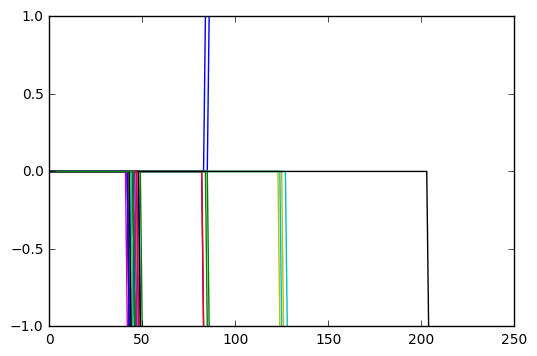

In [89]:
# visualize 
rewards = samples['rewards']
sum_1=0
sum_minus1=0
sum_0 = 0
for epi in range(len(rewards)):
    for rx in rewards[epi]:
        if rx == 1.0:
            sum_1 += 1
        elif rx == -1.0:
            sum_minus1 += 1
        else:
            sum_0 += 1
    plt.plot(rewards[epi])
print('reward 1 has ', sum_1)
print('reward -1 has ', sum_minus1)
print('reward 0 has ', sum_0)
plt.show()


In [90]:
# validate data
states = samples['states']
assert(len(states) == len(rewards))
image_size = (160, 160, 3)
total_data = 0
for epi in range(len(states)):
    assert(len(states[epi]) == len(rewards[epi]))
    assert(states[epi][0].shape == image_size)
    total_data += len(states[epi]) 
print('total data is %d' % total_data)   

# reformat data into nd-array
x_all = np.zeros((total_data, 10, 10), dtype = np.float32)
y_all = np.zeros((total_data, 3), dtype = np.float32)
index = 0
labels = np.zeros((total_data, 1), dtype = np.int)
for epi in range(len(states)):
    for i in range(len(states[epi])):
        x_all[index] = states[epi][i][::16, ::16, 0]
        if rewards[epi][i] == -1:
            labels[index] = 0
        elif rewards[epi][i] == 0:
            labels[index] = 1
        else: 
            labels[index] = 2
        y_all[index][labels[index]] = 1.0
        index += 1

total data is 2762


In [91]:
print(np.max(y_all))
print(np.min(y_all))
print(np.max(x_all))
print(np.min(x_all))
print(x_all.shape)
print(y_all.shape)
print(labels.shape)
print(np.unique(labels, return_counts = True))
# print(y_all)

1.0
0.0
236.0
109.0
(2762, 10, 10)
(2762, 3)
(2762, 1)
(array([0, 1, 2]), array([  42, 2718,    2]))


In [92]:
# split data
# train_size = int(total_data * 0.7)
# validate_size = int(total_data * 0.2)
# test_size = total_data - train_size - validate_size

# train_slices = range(0, train_size)
# validate_slices = range(train_size, train_size + validate_size)
# test_slices = range(train_size + validate_size, total_data)
# assert(total_data == len(train_slices) + len(validate_slices) + len(test_slices) )

# x_train = x_all[train_slices]
# y_train = y_all[train_slices]

# x_validate = x_all[validate_slices]
# y_validate = y_all[validate_slices]

# x_test = x_all[test_slices]
# y_test = y_all[test_slices]

# print(x_train[1:10].shape)

In [93]:
import tensorflow as tf

In [94]:
## multi-layer 
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [95]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x = tf.placeholder(tf.float32, shape=[None, 10, 10])
y_ = tf.placeholder(tf.float32, shape=[None, 3])

x_image = tf.reshape(x, [-1,10,10,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


In [96]:
W_conv2 = weight_variable([5, 5, 32, 20])
b_conv2 = bias_variable([20])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [97]:
W_fc1 = weight_variable([3 * 3 * 100, 100])
b_fc1 = bias_variable([100])

h_pool2_flat = tf.reshape(h_pool2, [-1, 3 * 3 * 100])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [98]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


In [99]:
W_fc2 = weight_variable([100, 3])
b_fc2 = bias_variable([3])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


In [100]:
sess = tf.InteractiveSession()
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
start = 0
end = 0
for i in range(100):
  end = start + 50
  print(x_all[start:end].shape)
  print(y_all[start:end].shape)
  if i%10 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:x_all[start:end], y_: y_all[start:end], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: x_all[start:end], y_: y_all[start:end], keep_prob: 0.5})
  start = end
  print('start = %d, end = %d' %(start, end))  

# print("test accuracy %g"%accuracy.eval(feed_dict={
#     x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

(50, 10, 10)
(50, 3)


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f9920d2a910>> ignored


InvalidArgumentError: Incompatible shapes: [10] vs. [50]
	 [[Node: Equal_12 = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](ArgMax_24, ArgMax_25)]]
Caused by op u'Equal_12', defined at:
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-100-a949f8d5af4c>", line 4, in <module>
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 715, in equal
    result = _op_def_lib.apply_op("Equal", x=x, y=y, name=name)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hyao/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()
